<a href="https://colab.research.google.com/github/Shashank-4321/Dynamic-Pricing-Strategies-for-Retail-A-Data-Driven-Approach/blob/main/project3gem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Generation synthetic data for model
import pandas as pd
import numpy as np
import os

# Parameters
n_rows = 1000000
np.random.seed(42)

# Define a fixed base price for each product
base_price_mapping = {
    "Chips": 15.0,
    "Soda": 25.0,
    "Biscuits": 20.0,
    "Juice": 30.0,
    "Namkeen": 22.0,
    "Water Bottle": 12.0,
    "Chocolate": 40.0,
    "Tea": 40.0, # Assuming per 100g/pack
    "Coffee": 150.0 # Assuming per 100g/pack
}
products = list(base_price_mapping.keys())

# Define a function to map month to season
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Autumn'

#2. Base Data Generation
cities = ["Mumbai", "Delhi", "Bengaluru", "Hyderabad", "Chennai", "Kolkata", "Pune", "Ahmedabad", "Jaipur"]
weather_conditions = ["Sunny", "Rainy", "Cloudy", "Humid", "Cold"]
time_slots = ["Morning", "Afternoon", "Evening", "Night"]

dates = pd.to_datetime(pd.to_datetime("2020-01-01") + pd.to_timedelta(np.random.randint(0, 365*4*24, n_rows), unit='h'))
month_values = dates.month
season_values = [get_season(m) for m in month_values]
product_choice = np.random.choice(products, n_rows)
city_choice = np.random.choice(cities, n_rows)
category_choice = ["Beverages" if p in ["Soda", "Juice", "Water Bottle", "Tea", "Coffee"] else "Snacks" for p in product_choice]
weather_choice = np.random.choice(weather_conditions, n_rows)
time_choice = np.random.choice(time_slots, n_rows)
stock = np.random.randint(50, 500, n_rows)

#3.Generate prices based on the fixed base price ---
base_price_values = [base_price_mapping[p] for p in product_choice]
# Retail price is the base price plus a random markup from 5% to 50%
markup = 1 + np.random.uniform(0.05, 0.50, n_rows)
retail_price_values = np.array(base_price_values) * markup

#4.Realistic Demand Multipliers
demand_multiplier = np.ones(n_rows)
demand_multiplier[np.isin(season_values, ['Summer']) & np.isin(product_choice, ['Soda', 'Juice', 'Water Bottle'])] *= 2.0
demand_multiplier[np.isin(season_values, ['Winter']) & np.isin(product_choice, ['Tea', 'Coffee'])] *= 1.8
demand_multiplier[np.isin(weather_choice, ['Sunny']) & np.isin(product_choice, ['Soda', 'Juice'])] *= 1.5
demand_multiplier[np.isin(weather_choice, ['Rainy', 'Cold']) & np.isin(product_choice, ['Tea', 'Coffee'])] *= 2.0
demand_multiplier[np.isin(time_choice, ['Evening']) & np.isin(product_choice, ['Chips', 'Namkeen'])] *= 1.5

#5.Units Sold Formula (driven by retail_price)
# Higher retail prices will now lead to lower sales
price_effect = (np.array(base_price_values) * 1.5 - retail_price_values) # The higher the markup, the lower the effect
price_effect[price_effect < 0] = 0
units_sold = ((stock * 0.02) + (price_effect) + np.random.normal(0, 5, n_rows)) * demand_multiplier
units_sold = np.clip(units_sold, 1, None).astype(int)

#6.Financial Calculations based on base and retail prices
revenue = units_sold * retail_price_values
profit = (retail_price_values - np.array(base_price_values)) * units_sold

#7. Create and Save DataFrame
df = pd.DataFrame({
    "date": dates.date,
    "month": month_values,
    "season": season_values,
    "time_slot": time_choice,
    "city": city_choice,
    "product": product_choice,
    "category": category_choice,
    "weather": weather_choice,
    "base_price": np.array(base_price_values).round(2), # NEW column
    "retail_price": retail_price_values.round(2), # Formerly 'price'
    "stock": stock,
    "units_sold": units_sold,
    "revenue": revenue.round(2),
    "profit": profit.round(2) # New calculation
})

# Save the file
save_dir = r""#Here enter your path where you want to save your data
os.makedirs(save_dir, exist_ok=True)
file_path = os.path.join(save_dir, "synthetic_pricing_dataset_v4_10lac.csv")
df.to_csv(file_path, index=False)

print(f"Dataset with base price logic saved at: {file_path}")
print("\nSample of the new data with base and retail prices:")
print(df[['product', 'base_price', 'retail_price', 'units_sold', 'profit']].head())

In [ ]:
import pandas as pd
# Load your dataset from the CSV file into a pandas DataFrame
df = pd.read_csv('synthetic_pricing_dataset_v4_10lac.csv')

# Used.head() function to display the first 5 rows of data
# This is a quick way to make sure that the data is loaded correctly.
print("Here are the first 5 rows of your dataset:")
df.head()

Here are the first 5 rows of your dataset:


,date,month,season,time_slot,city,product,category,weather,base_price,retail_price,stock,units_sold,revenue,profit
0,2021-10-20,10,Autumn,Evening,Mumbai,Chocolate,Snacks,Sunny,40.0,54.43,380,28,1524.06,404.06
1,2020-02-05,2,Winter,Night,Jaipur,Coffee,Beverages,Humid,150.0,199.01,264,53,10547.64,2597.64
2,2021-04-15,4,Summer,Afternoon,Jaipur,Juice,Beverages,Rainy,30.0,39.27,409,39,1531.72,361.72
3,2020-09-18,9,Monsoon,Afternoon,Ahmedabad,Chips,Snacks,Humid,15.0,16.36,55,7,114.51,9.51
4,2021-12-03,12,Winter,Morning,Kolkata,Biscuits,Snacks,Humid,20.0,28.61,470,8,228.86,68.86


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
import joblib

#1. Load and Feature Engineer Our Dataset ---
df = pd.read_csv('synthetic_pricing_dataset_v4_10lac.csv')

# Create time-based features
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = (df['date'].dt.weekday >= 5).astype(int)

# Create log-transformed financial features for stability
df['retail_price_log'] = np.log1p(df['retail_price'])
df['profit_log'] = np.log1p(df['profit'])
df['markup'] = (df['retail_price'] - df['base_price']) / df['base_price']

#Define Features and Target Variable
target = 'units_sold'

# The features are all the variables that could influence sales
features = [
    'month', 'stock', 'base_price', 'retail_price', 'day_of_week', 'is_weekend',
    'retail_price_log', 'profit_log', 'markup',
    'season', 'time_slot', 'city', 'product', 'category', 'weather'
]

X = df[features]
y = df[target]

# One-hot encode all categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print(f"Training Set Size: {len(X_train)}")
print(f"Test Set Size: {len(X_test)}")
print("\n--- Model Comparison ---")

# Train and Evaluate Multiple Models
models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - Mean Absolute Error: {mae:.2f}")
    print(f"{name} - R^2 Score: {r2:.4f}")
    print("-----")

#Hyperparameter Tuning for the Best Model (Random Forest) ---
print("\n--- Hyperparameter Tuning for Random Forest ---")
# We will test a smaller grid to run faster in this environment
param_grid = {
    'n_estimators': [100, 200], # Number of trees in the forest
    'max_depth': [10, 20],      # Maximum depth of the tree
    'min_samples_leaf': [5, 10] # Minimum number of samples required at a leaf node
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
                           param_grid=param_grid,
                           cv=3, # 3-fold cross-validation
                           scoring='neg_mean_absolute_error', # Optimize for MAE
                           verbose=2)

grid_search.fit(X_train, y_train)

best_mae = -grid_search.best_score_
print(f"\nBest Parameters from Tuning: {grid_search.best_params_}")
print(f"Best Cross-Validated MAE: {best_mae:.2f}")

# --- 5. Feature Selection ---
print("\n--- Feature Selection ---")
best_model = grid_search.best_estimator_

# Select features with an importance greater than the mean
selector = SelectFromModel(best_model, prefit=True, threshold='mean')
support = selector.get_support()
selected_features = X_encoded.columns[support]

print("Top selected features driving sales:")
print(selected_features.tolist())

# --- 6. Save the Final, Tuned Model ---
joblib.dump(best_model, 'tuned_demand_model.pkl')
print("\nFinal tuned model saved as 'tuned_demand_model.pkl'")

Training Set Size: 800000
Test Set Size: 200000

--- Model Comparison ---
Ridge Regression - Mean Absolute Error: 7.24
Ridge Regression - R^2 Score: 0.7932
-----
Lasso Regression - Mean Absolute Error: 7.22
Lasso Regression - R^2 Score: 0.7858
-----
Random Forest - Mean Absolute Error: 0.91
Random Forest - R^2 Score: 0.9961
-----

--- Hyperparameter Tuning for Random Forest ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=100; total time= 6.3min
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=100; total time= 6.4min
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=100; total time= 6.5min
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=200; total time=13.0min
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=200; total time=12.2min
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=200; total time=12.5min
[CV] END max_depth=10, min_samples_leaf=10, n_estimators=100; total time=

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# Load Your Best Dataset
df = pd.read_csv('synthetic_pricing_dataset_v4_10lac.csv')

# Feature Engineering
# Create all the valuable features we've discussed
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
df['is_weekend'] = (df['date'].dt.weekday >= 5).astype(int)
df['markup_percentage'] = ((df['retail_price'] - df['base_price']) / df['base_price']) * 100

# Our target is 'units_sold'
target = 'units_sold'

# All the features that will help predict the target
features = [
    'month', 'stock', 'base_price', 'retail_price', 'day_of_week',
    'day_of_year', 'is_weekend', 'markup_percentage',
    'season', 'time_slot', 'city', 'product', 'category', 'weather'
]
#Define Features (X) and Target (y)
X = df[features]
y = df[target]

# One-hot encode all categorical (text) features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Create and Train the Random Forest Model
print("Training the simulator engine")

# Use configuration for high accuracy
simulator_engine = RandomForestRegressor(
    n_estimators=100,      # Number of "decision trees" in the forest
    max_depth=20,          # How deep each tree can be
    min_samples_leaf=5,    # Helps prevent the model from overfitting
    random_state=42,
    n_jobs=-1

simulator_engine.fit(X_train, y_train)
print("Training complete!")

#Evaluate the Engine's Accuracy
print("\n--- Evaluating Simulator Engine ---")
predictions = simulator_engine.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.4f}")

# Save the Final Engine
joblib.dump(simulator_engine, 'simulator_engine.pkl')
# We also need to save the exact column layout the model was trained on
model_columns = X_encoded.columns.tolist()
with open('model_columns.json', 'w') as f:
    import json
    json.dump(model_columns, f)

print("\nSimulator engine and columns saved successfully!")

Training the simulator engine (Random Forest)... This may take a minute.
Training complete!

--- Evaluating Simulator Engine ---
Mean Absolute Error (MAE): 5.06
R^2 Score: 0.9334

Simulator engine and columns saved successfully!


In [ ]:
import pandas as pd
import numpy as np
import joblib
import json

class MarketSimulator:
    def __init__(self, model_path, columns_path, data_path):
        print("Initializing the Market Simulator...")
        self.engine = joblib.load(model_path)
        with open(columns_path, 'r') as f:
            self.model_columns = json.load(f)

        # Load the raw data
        self.df = pd.read_csv(data_path)

        # Perform all necessary feature engineering upon initialization
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df['day_of_week'] = self.df['date'].dt.dayofweek
        self.df['is_weekend'] = (self.df['day_of_week'] >= 5).astype(int)
        self.df['cost_per_unit'] = (self.df['revenue'] - self.df['profit']) / self.df['units_sold']

        print("Simulator is ready with all features.")

    def get_market_response(self, state, action_price):
        query = ' & '.join([f'`{k}`=="{v}"' for k, v in state.items() if k in self.df.columns])
        example_row = self.df.query(query)
        if example_row.empty:
            return 0

        cost = example_row.iloc[0]['cost_per_unit']

        input_data = state.copy()
        input_data['retail_price'] = action_price

        for feature in ['base_price', 'stock', 'month', 'day_of_week', 'day_of_year', 'is_weekend', 'markup_percentage', 'category']:
             if feature not in input_data and feature in self.df.columns:
                 input_data[feature] = example_row.iloc[0][feature]

        input_df = pd.DataFrame([input_data])
        input_encoded = pd.get_dummies(input_df)
        input_reordered = input_encoded.reindex(columns=self.model_columns, fill_value=0)

        predicted_demand = self.engine.predict(input_reordered)[0]
        predicted_demand = max(0, round(predicted_demand))

        profit = (action_price - cost) * predicted_demand

        return profit

Initializing the Market Simulator...
Simulator is ready.
Realistic price range for Juice found: ₹30.00 to ₹54.00


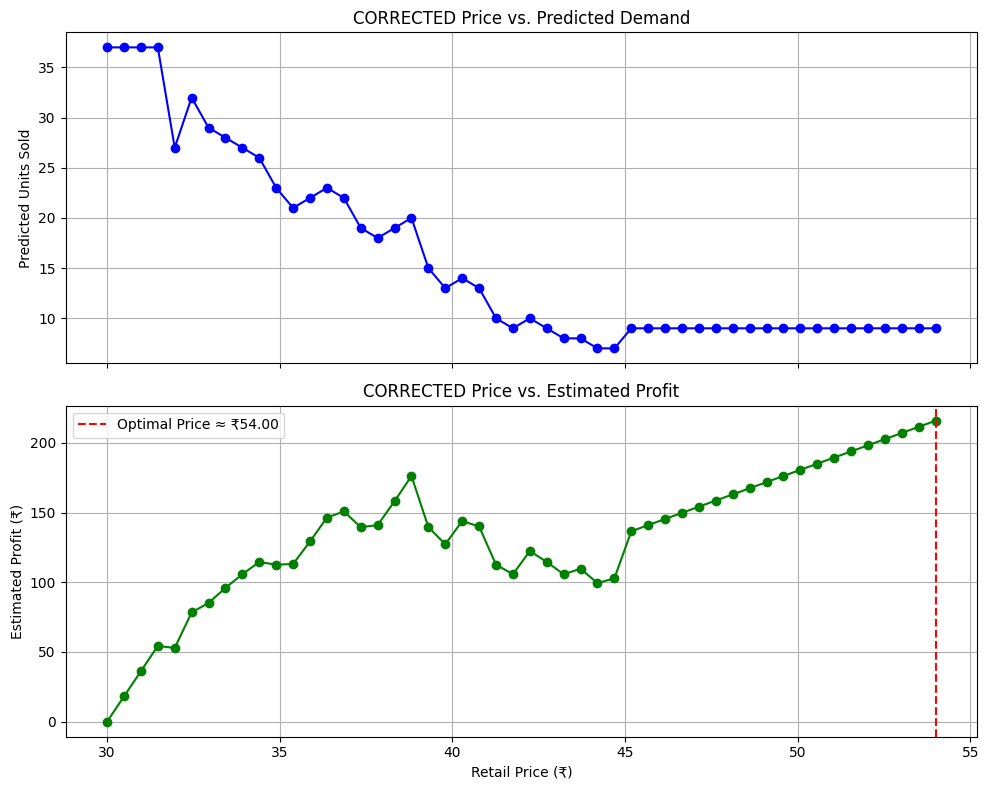

In [ ]:
#Initialize the Simulator
simulator = MarketSimulator(
    model_path='simulator_engine.pkl',
    columns_path='model_columns.json',
    data_path='synthetic_pricing_dataset_v4_10lac.csv'
)

#Define the Scenario
test_state = {
    'product': 'Juice',
    'city': 'Delhi',
    'season': 'Summer',
    'weather': 'Humid',
    'time_slot': 'Afternoon'
}

# Get the Sensible Price Range from the Simulator
min_p, max_p = simulator.get_product_price_range('Juice')
print(f"Realistic price range for Juice found: ₹{min_p:.2f} to ₹{max_p:.2f}")

test_prices = np.linspace(min_p, max_p, 50)
demands = []
profits = []

# Run the simulation for each price
for price in test_prices:
    demand, profit = simulator.get_detailed_market_response(test_state, price)
    demands.append(demand)
    profits.append(profit)

# Plot the Corrected Results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot 1: Price vs. Demand
ax1.plot(test_prices, demands, 'b-o')
ax1.set_title('CORRECTED Price vs. Predicted Demand')
ax1.set_ylabel('Predicted Units Sold')
ax1.grid(True)

# Plot 2: Price vs. Profit
ax2.plot(test_prices, profits, 'g-o')
ax2.set_title('CORRECTED Price vs. Estimated Profit')
ax2.set_xlabel('Retail Price (₹)')
ax2.set_ylabel('Estimated Profit (₹)')
ax2.axvline(x=test_prices[np.argmax(profits)], color='r', linestyle='--', label=f'Optimal Price ≈ ₹{test_prices[np.argmax(profits)]:.2f}')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import random

class QLearningAgent:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0):
        self.actions = actions
        self.alpha = learning_rate    # How much we update our Q-values
        self.gamma = discount_factor  # How much we value future rewards
        self.epsilon = exploration_rate # How often we take a random action (explore)
        self.q_table = pd.DataFrame(columns=self.actions)

    def check_state_exist(self, state):
        """Adds a new state to the Q-table if it's the first time we've seen it."""
        if state not in self.q_table.index:
            self.q_table.loc[state] = [0.0] * len(self.actions)

    def choose_action(self, state):
        """Decides on an action using an epsilon-greedy strategy."""
        self.check_state_exist(state)
        # With probability epsilon, we take a random action (explore)
        if np.random.uniform() < self.epsilon:
            action = np.random.choice(self.actions)
        # Otherwise, we take the best action we know so far (exploit)
        else:
            state_actions = self.q_table.loc[state, :]
            action = np.random.choice(state_actions[state_actions == np.max(state_actions)].index)
        return action

    def learn(self, state, action, reward):
        """Updates the Q-table based on the reward received from an action."""
        self.check_state_exist(state)
        q_predict = self.q_table.loc[state, action]
        # The core Q-learning formula (Bellman equation)
        # For a simple problem, we assume the next state has a value of 0.
        q_target = reward
        self.q_table.loc[state, action] += self.alpha * (q_target - q_predict)

In [ ]:
#Initialization
simulator = MarketSimulator(
    model_path='simulator_engine.pkl',
    columns_path='model_columns.json',
    data_path='synthetic_pricing_dataset_v4_10lac.csv'
)

actions = ['markup_10', 'markup_20', 'markup_30', 'markup_40', 'markup_50']
agent = QLearningAgent(actions=actions)

num_episodes = 20000
initial_epsilon = 1.0
final_epsilon = 0.01
epsilon_decay = initial_epsilon / (num_episodes * 0.8)

print(f"Starting Q-learning training for {num_episodes} episodes...")

# The Main Training Loop
for episode in range(num_episodes):
    random_row = simulator.df.sample(n=1).iloc[0]
    product = random_row['product']
    is_weekend = random_row['is_weekend'] == 1
    current_state_key = f"{product}_Weekend" if is_weekend else f"{product}_Weekday"

    chosen_action = agent.choose_action(current_state_key)
    markup = int(chosen_action.split('_')[1]) / 100.0
    base_price = random_row['base_price']
    action_price = base_price * (1 + markup)

    full_state_details = {
        'product': random_row['product'],
        'city': random_row['city'],
        'season': random_row['season'],
        'weather': random_row['weather'],
        'time_slot': random_row['time_slot']
    }
    reward = simulator.get_market_response(full_state_details, action_price)

    agent.learn(current_state_key, chosen_action, reward)

    if agent.epsilon > final_epsilon:
        agent.epsilon -= epsilon_decay

    if (episode + 1) % 5000 == 0:
        print(f"Episode {episode + 1}/{num_episodes} complete. Epsilon: {agent.epsilon:.3f}")

print("\n--- Training Complete! ---")
print("The agent's learned Q-table (strategy guide):")
sorted_q_table = agent.q_table.sort_index()
print(sorted_q_table)

Initializing the Market Simulator...
Simulator is ready with all features.
Starting Q-learning training for 20000 episodes...
Episode 5000/20000 complete. Epsilon: 0.688
Episode 10000/20000 complete. Epsilon: 0.375
Episode 15000/20000 complete. Epsilon: 0.063
Episode 20000/20000 complete. Epsilon: 0.010

--- Training Complete! ---
The agent's learned Q-table (strategy guide):
                        markup_10    markup_20    markup_30    markup_40  \
Biscuits_Weekday        30.277334    55.955443    76.005388   105.418978   
Biscuits_Weekend        28.641839    56.203850    88.912947   107.958559   
Chips_Weekday           19.083075    39.577886    60.883488    77.213243   
Chips_Weekend           18.282511    39.919384    58.214914    89.322547   
Chocolate_Weekday       82.351728   160.797184   222.476954   309.994809   
Chocolate_Weekend       85.155724   154.318182   231.442899   323.480468   
Coffee_Weekday        1992.395617  3106.549255  4155.007636  4619.785253   
Coffee_Weeken

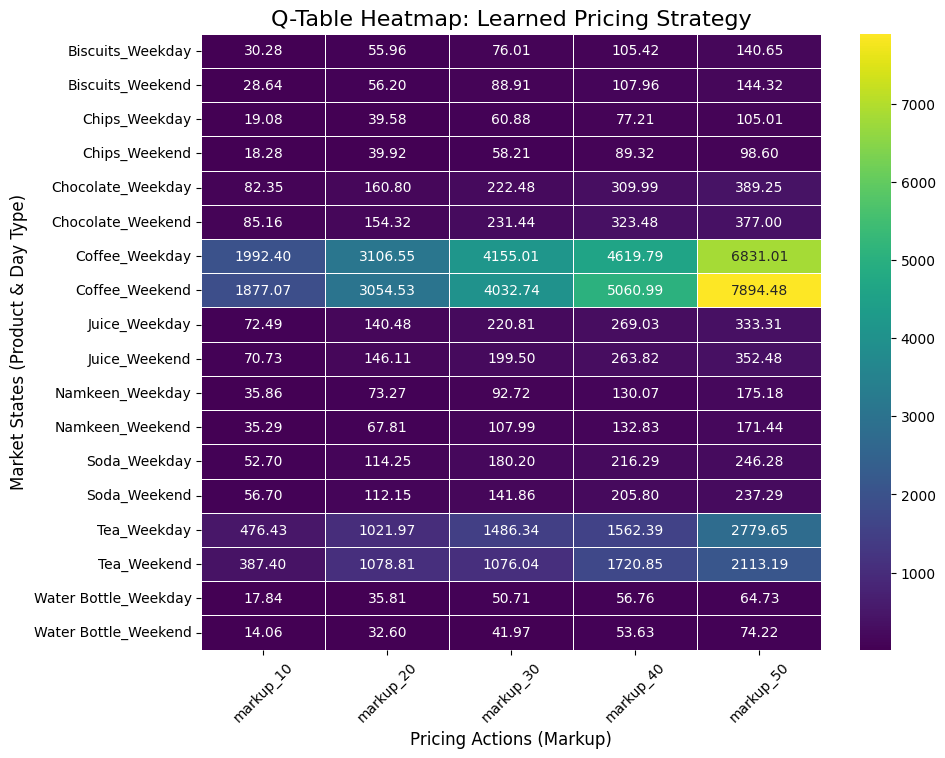

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plotting the Q-Table as a Heatmap
plt.figure(figsize=(10, 8)) # Set the figure size for better readability

# Use seaborn to create the heatmap
sns.heatmap(
    sorted_q_table,
    annot=True,      # Show the Q-values on the chart
    fmt=".2f",       # Format the numbers to two decimal places
    cmap="viridis",  # Use a color-friendly palette ("viridis", "plasma", "coolwarm")
    linewidths=.5
)

plt.title('Q-Table Heatmap: Learned Pricing Strategy', fontsize=16)
plt.xlabel('Pricing Actions (Markup)', fontsize=12)
plt.ylabel('Market States (Product & Day Type)', fontsize=12)
plt.xticks(rotation=45) # Rotate x-axis labels for better fit
plt.yticks(rotation=0)
plt.show()

In [1]:
# Save the Q-Table
q_table_filename = 'q_learning_strategy.csv'
sorted_q_table.to_csv(q_table_filename)
print(f"✅ Agent's Q-table saved successfully to: {q_table_filename}")

NameError: name 'sorted_q_table' is not defined

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns

#Page Configuration
st.set_page_config(layout="wide", page_title="Dynamic Pricing Agent Explorer")

#Load All Project Assets
@st.cache_resource
def load_assets():
    """Loads all saved models and data to be used in the app."""
    simulator = joblib.load('simulator_engine.pkl')
    with open('model_columns.json', 'r') as f:
        model_columns = json.load(f)
    q_table = pd.read_csv('q_learning_strategy.csv', index_col=0)
    df = pd.read_csv('synthetic_pricing_dataset_v4_10lac.csv')
    df['date'] = pd.to_datetime(df['date'])
    df['is_weekend'] = (df['date'].dt.weekday >= 5).astype(int)
    return simulator, model_columns, q_table, df

simulator_engine, model_columns, q_table, df = load_assets()
products = sorted(df['product'].unique())

# Helper Functions
def get_market_response(state, action_price):
    """Uses the simulator engine to predict demand and calculate profit."""
    query = f'product == "{state["product"]}"'
    example_row = df.query(query).iloc[0]
    cost = (example_row['revenue'] - example_row['profit']) / example_row['units_sold']

    input_data = state.copy()
    input_data['retail_price'] = action_price

    # Add other necessary features for the model
    for feature in ['base_price', 'stock', 'month', 'day_of_week', 'day_of_year', 'is_weekend', 'markup_percentage', 'category']:
        if feature not in input_data and feature in df.columns:
            input_data[feature] = example_row[feature]

    input_df = pd.DataFrame([input_data])
    input_encoded = pd.get_dummies(input_df)
    input_reordered = input_encoded.reindex(columns=model_columns, fill_value=0)

    predicted_demand = simulator_engine.predict(input_reordered)[0]
    predicted_demand = max(0, round(predicted_demand))
    profit = (action_price - cost) * predicted_demand
    return profit

# UI Layout
st.title("🧠 Q-Learning Pricing Agent Explorer")
st.write("An interactive dashboard to explore the strategy of a trained Reinforcement Learning agent and compare its performance against a static pricing model.")

st.sidebar.header("Simulation Settings")
selected_product = st.sidebar.selectbox("Select a Product to Analyze", products)

# --- Display Agent's Learned Strategy ---
st.header(f"Agent's Learned Strategy for: `{selected_product}`")
col1, col2 = st.columns(2)

with col1:
    st.write("This table shows the expected profit for each pricing action. The agent will always choose the action with the highest value.")
    product_q_values = q_table[q_table.index.str.contains(selected_product)]
    st.dataframe(product_q_values.style.highlight_max(axis=1, color='lightgreen'))

with col2:
    # Find and display the best actions
    best_weekday_action = product_q_values.loc[f"{selected_product}_Weekday"].idxmax()
    best_weekend_action = product_q_values.loc[f"{selected_product}_Weekend"].idxmax()
    st.metric("Recommended Weekday Strategy", best_weekday_action.replace("_", " ").title())
    st.metric("Recommended Weekend Strategy", best_weekend_action.replace("_", " ").title())

# --- Performance Comparison Simulation ---
st.header("Performance Showdown: Dynamic vs. Static Pricing")
static_markup_pct = st.slider("Select a static markup % for the comparison model:", 10, 50, 30)

if st.button("🚀 Run 30-Day Simulation"):
    # Filter data for the selected product
    product_df = df[df['product'] == selected_product].sample(n=30, random_state=42)

    agent_profits = []
    static_profits = []

    for _, row in product_df.iterrows():
        # --- Agent's Turn ---
        is_weekend = row['is_weekend'] == 1
        state_key = f"{selected_product}_Weekend" if is_weekend else f"{selected_product}_Weekday"
        agent_action = q_table.loc[state_key].idxmax()
        agent_markup = int(agent_action.split('_')[1]) / 100.0
        agent_price = row['base_price'] * (1 + agent_markup)

        #Static Model's Turn
        static_price = row['base_price'] * (1 + static_markup_pct / 100.0)

        # Get Market Response for Both
        market_state = row.to_dict()
        agent_profit = get_market_response(market_state, agent_price)
        static_profit = get_market_response(market_state, static_price)

        agent_profits.append(agent_profit)
        static_profits.append(static_profit)

    # Display Simulation Results
    total_agent_profit = sum(agent_profits)
    total_static_profit = sum(static_profits)
    profit_uplift = ((total_agent_profit - total_static_profit) / total_static_profit) * 100 if total_static_profit > 0 else 0

    st.subheader("Simulation Results")
    res_col1, res_col2, res_col3 = st.columns(3)
    res_col1.metric("Q-Agent Total Profit", f"₹{total_agent_profit:,.2f}")
    res_col2.metric("Static Model Total Profit", f"₹{total_static_profit:,.2f}")
    res_col3.metric("Profit Uplift", f"{profit_uplift:.2f}%", delta_color="normal")

    # Plot cumulative profits
    chart_data = pd.DataFrame({
        'Day': range(1, 31),
        'Dynamic Agent Profit': np.cumsum(agent_profits),
        'Static Model Profit': np.cumsum(static_profits)
    })
    st.line_chart(chart_data.set_index('Day'))

Overwriting app.py


In [ ]:
!pip -q install streamlit pyngrok

NGROK_TOKEN = "31GrqDiX70m1uCMjLNEpkcc9tKJ_4cyyJHazMro87jFc8wtq2"
!ngrok config add-authtoken $NGROK_TOKEN

!bash -lc 'cd /content && streamlit run app.py --server.port 8501 --server.address 0.0.0.0 >/content/streamlit.log 2>&1 &'

from pyngrok import ngrok
tunnel = ngrok.connect(8501, "http")
print("Public URL:", tunnel.public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Public URL: https://885dae7ac622.ngrok-free.app
